# Problem1

In [1]:
import torch
# import torch.nn.functional as F
import matplotlib.pyplot as plt
import math


In [2]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.hidden1 = torch.nn.Linear(n_hidden, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer
        self.tan = torch.nn.Tanh()

    def forward(self, x):
        x = self.tan(self.hidden(x))
        x = self.predict(x)
        return x


Early stop at 528 epochs with loss less than 0.001.


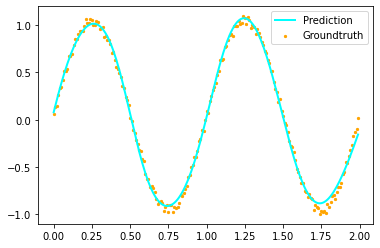

In [13]:
x = torch.unsqueeze(torch.arange(0, 2, 0.01), dim=1)
y = torch.sin(2*math.pi*x) + 0.1*torch.rand(x.size())

net = Net(n_feature=1, n_hidden=10, n_output=1)
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
loss_func = torch.nn.SmoothL1Loss()

for t in range(2000):
    prediction = net(x)

    loss = loss_func(prediction, y)
    if loss < 0.001:
        print(f'Early stop at {t} epochs with loss less than 0.001.')
        break

    optimizer.zero_grad()   # clear gradients
    loss.backward()         # backpropagation
    optimizer.step()        # apply gradients

plt.clf()
plt.plot(x.numpy(), prediction.data.numpy(),
         '-', c='cyan', lw=2, label='Prediction')
plt.scatter(x.numpy(), y.data.numpy(), c='orange', s=5, label='Groundtruth')
plt.legend()
plt.show()


模型訓練528 epochs後收斂。但最終收斂所需之epoch數與ANN的neuron數量相關，若數量過少，模型不一定可良好的預測，若過多可能會過擬合。

# Problem2

In [4]:
import os
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt


c:\Users\Yun\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# Parameters
EPOCH = 2                          # train the training data n times
BATCH_SIZE = 100
learning_rate = 0.001              # learning rate


# Mnist digits dataset
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    # not mnist dir or mnist is empyt dir
    DOWNLOAD_MNIST = True
# training data
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,
    # normalize in the range [0.0, 1.0]
    transform=torchvision.transforms.ToTensor(),

    download=True,
)


print(train_data.train_data.size())                 # ([60000, 28, 28])
print(train_data.train_labels.size())               # ([60000])
# image batch shape (6000, 1, 28, 28)
train_loader = Data.DataLoader(
    dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# 2000 samples testing data
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[
    :2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]


torch.Size([60000, 28, 28])
torch.Size([60000])


c:\Users\Yun\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\Users\Yun\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
c:\Users\Yun\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\Users\Yun\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [6]:
# CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # padding=(kernel_size-1)/2
            ),                              # output shape (16, 28, 28)
            nn.BatchNorm2d(16),             # Batch Normalization
            nn.ReLU(),                      # activation
            # choose max value in 2x2 area, output shape (16, 14, 14)
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.BatchNorm2d(32),             # Batch Normalization
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.fc_layers = nn.Sequential(
            # fully connected layer, output 256 classes
            nn.Linear(32 * 7 * 7, 256),
            nn.ReLU(),                      # activation
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output to (batch_size, 32 * 7 * 7)
        x = x.flatten(1)
        x = self.fc_layers(x)
        output = self.out(x)
        output = nn.functional.softmax(output, dim=1)   # softmax
        return output


In [7]:
cnn = CNN()
# optimize all cnn parameters
opti = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

# training and testing
for epoch in range(EPOCH):
    for step, (train_x, train_y) in enumerate(train_loader):   # batch data

        output = cnn(train_x)               # cnn output
        loss = loss_func(output, train_y)   # cross entropy loss
        opti.zero_grad()                    # clear gradients for this training step
        loss.backward()                     # backpropagation
        opti.step()                         # apply gradients

        if step % 50 == 0:
            test_output = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(
                int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' %
                  loss.data.numpy(), '| test accuracy: %.2f' % accuracy)


# final accuracy
train_output = cnn(train_x)
pred_y = torch.max(train_output, 1)[1].data.numpy()
train_accuracy = float((pred_y == train_y.data.numpy()).astype(
    int).sum()) / float(train_y.size(0))
test_output = cnn(test_x)
pred_y = torch.max(test_output, 1)[1].data.numpy()
test_accuracy = float((pred_y == test_y.data.numpy()).astype(
    int).sum()) / float(test_y.size(0))
print('learning rate : '+str(learning_rate))
print('batch size : '+str(BATCH_SIZE))
print('EPOCH : '+str(EPOCH))
print('final_test_accuracy : '+str(test_accuracy))
print('final_train_accuracy : '+str(train_accuracy))


Epoch:  0 | train loss: 2.3080 | test accuracy: 0.13
Epoch:  0 | train loss: 1.5833 | test accuracy: 0.93
Epoch:  0 | train loss: 1.5159 | test accuracy: 0.95
Epoch:  0 | train loss: 1.4865 | test accuracy: 0.95
Epoch:  0 | train loss: 1.4938 | test accuracy: 0.97
Epoch:  0 | train loss: 1.5109 | test accuracy: 0.97
Epoch:  0 | train loss: 1.4846 | test accuracy: 0.97
Epoch:  0 | train loss: 1.4898 | test accuracy: 0.96
Epoch:  0 | train loss: 1.4966 | test accuracy: 0.96
Epoch:  0 | train loss: 1.4822 | test accuracy: 0.97
Epoch:  0 | train loss: 1.4768 | test accuracy: 0.97
Epoch:  0 | train loss: 1.4980 | test accuracy: 0.97
Epoch:  1 | train loss: 1.4847 | test accuracy: 0.97
Epoch:  1 | train loss: 1.4785 | test accuracy: 0.97
Epoch:  1 | train loss: 1.4891 | test accuracy: 0.97
Epoch:  1 | train loss: 1.4894 | test accuracy: 0.98
Epoch:  1 | train loss: 1.4710 | test accuracy: 0.98
Epoch:  1 | train loss: 1.4821 | test accuracy: 0.98
Epoch:  1 | train loss: 1.4841 | test accuracy

**Parameters**<br>
EPOCH = 2<br>
BATCH_SIZE = 100<br>
learning_rate = 0.001<br>